In [ ]:
# Copyright (c) 2023 Graphcore Ltd. All rights reserved.
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import jax
import jax.numpy as jnp
import seaborn as sns

from jax import vjp
from jax.numpy import *
from jax.nn import gelu
from jax.random import PRNGKey, split, normal

sns.set_theme()

In [ ]:
# !apt install texlive-latex-base
!apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript javascript-common
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpdfbox-java libptexenc1 libruby2.7 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  t1utils tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf g

In [ ]:
def ffn_fwd_bwd(x1, w1, w2, x4_grad):
  x2 = x1 @ w1
  x3, relu_vjp = vjp(gelu, x2)
  x4 = x3 @ w2

  x3_grad = x4_grad @ transpose(w2)
  w2_grad = transpose(x3) @ x4_grad
  x2_grad = relu_vjp(x3_grad)[0]
  x1_grad = x2_grad @ transpose(w1)
  w1_grad = transpose(x1) @ x2_grad

  return [
    {'w1': w1, 'w1_grad': w1_grad, 'x1': x1, 'x1_grad': x1_grad},
    {'x2': x2, 'x2_grad': x2_grad},
    {'x3': x3, 'x3_grad': x3_grad},
    {'w2': w2, 'w2_grad': w2_grad, 'x4': x4, 'x4_grad': x4_grad},
  ]

In [ ]:
def ffn_fwd_bwd_us(x1, w1, w2, x4_grad):
  b, d = x1.shape

  x2 = x1 @ w1 / sqrt(2*d)
  x3, relu_vjp = vjp(gelu, x2)
  x3 /= 0.42675644
  x4 = x3 @ w2 / sqrt(2*d)

  x3_grad = x4_grad @ transpose(w2) / sqrt(2*d)
  w2_grad = transpose(x3) @ x4_grad / sqrt(b)
  x2_grad = relu_vjp(x3_grad)[0] / 0.42675644
  x1_grad = x2_grad @ transpose(w1) / sqrt(2*d)
  w1_grad = transpose(x1) @ x2_grad / sqrt(b)

  return [
    {'w1': w1, 'w1_grad': w1_grad, 'x1': x1, 'x1_grad': x1_grad},
    {'x2': x2, 'x2_grad': x2_grad},
    {'x3': x3, 'x3_grad': x3_grad},
    {'w2': w2, 'w2_grad': w2_grad, 'x4': x4, 'x4_grad': x4_grad},
  ]

In [ ]:
def gen_inputs(b, d, w_std=1.0, seed=1):
  x_key, w1_key, w2_key, v_key = split(PRNGKey(seed), 4)
  x = normal(x_key, (b, d))
  w1 = normal(w1_key, (d, 4 * d)) * w_std
  w2 = normal(w2_key, (4 * d, d)) * w_std
  v = normal(v_key, (b, d))
  return x, w1, w2, v

In [ ]:
def analyse(reg_layer_tensors, us_layer_tensors, dpi=100):
  reg_df = to_df(reg_layer_tensors)
  us_df = to_df(us_layer_tensors)
  visualise(reg_df, us_df, dpi)

def to_df(layer_tensors):
  data = {}
  bins = array(
    # [float('-inf')] +
    [e for e in range(-14, 16+1)]
    # + [float('inf')]
  )
  for i, ts in enumerate(layer_tensors):
    for t_name, t in ts.items():
      h = histogram(log(abs(t)), bins, density=True)[0]
      data[t_name] = h
      # print(f"{t_name}: {std(t):.3f}")
  return pd.DataFrame(data, index=bins[:-1])

def latex_col_names(names):
  return [
    fr'$\nabla_{{{n[0]}_{n[1]}}}$' if '_grad' in n else fr'${n[0]}_{n[1]}$'
    for n in names
  ]

def get_color(name):
  if 'w' in name:
    if 'grad' in name:
      return 'Reds'
    else:
      return 'Greens'
  if 'x' in name:
    if 'grad' in name:
      return 'Oranges'
    else:
      return 'Blues'

def visualise(reg_df, us_df, dpi):
  matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
  matplotlib.rc('text', usetex=True)

  _, axs = plt.subplots(2, 4, sharey=True, figsize=(8, 5), gridspec_kw={'width_ratios': [2, 1, 1, 2]}, dpi=dpi)
  bins = list(range(-14, 15 + 1))
  bin_edges = [str(b) if b % 3 == 0 else "" for b in bins]

  def apply_heatmap(data, cmap, ax):
    sns.heatmap(data[::-1], vmin=0.001, cmap=cmap, cbar=False, vmax=1, ax=ax)

  col_groups = [
    ['w1', 'w1_grad', 'x1', 'x1_grad'],
    ['x2', 'x2_grad'],
    ['x3', 'x3_grad'],
    ['w2', 'w2_grad', 'x4', 'x4_grad'],
  ]

  for df, h_axs in zip([reg_df, us_df], axs):
    sub_dfs = (df.loc[:, cols] for cols in col_groups)
    for sub_df, ax in zip(sub_dfs, h_axs):
      for i, col_name in enumerate(sub_df.columns):
        sub_df_copy = sub_df.copy()
        sub_df_copy.columns = latex_col_names(sub_df_copy.columns)
        sub_df_copy.iloc[:, :] = float('nan')
        sub_df_copy.iloc[:, i] = sub_df.iloc[:, i]

        apply_heatmap(sub_df_copy, get_color(col_name), ax)
      ax.hlines(y=16-8, color='grey', linestyle='--', lw=0.5, xmin=0, xmax=len(sub_df.columns))
      ax.hlines(y=16-(-7), color='grey', linestyle='--', lw=0.5, xmin=0, xmax=len(sub_df.columns))
    h_axs[0].tick_params(left=True, width=0.5, rotation=0, which='both', color='grey')
    h_axs[0].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(3))
  
  for i in range(4):
    axs[0, i].set_xticks([])
    axs[1, i].tick_params(axis='x', labelsize=14, pad=0)
  # plt.yticks([b + 14.5 for b in bins], reversed(bin_edges))

  t_reg = plt.text(.94, .95, 'Loss Scaling', ha='right', va='top', transform=axs[0, 3].transAxes)
  t_reg.set_bbox(dict(facecolor='white', edgecolor='black'))
  t_us = plt.text(.94, .95, 'Unit Scaling', ha='right', va='top', transform=axs[1, 3].transAxes)
  t_us.set_bbox(dict(facecolor='white', linestyle='dashed', edgecolor='black'))
  t_us = plt.text(-0.18, 1.14, 'Exponent value', ha='left', va='top', transform=axs[0, 0].transAxes)
  plt.subplots_adjust(hspace=0.1)

## Results

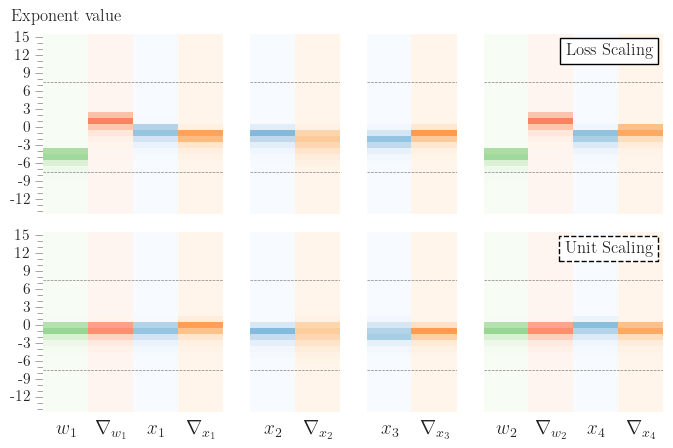

In [ ]:
# b, d = 256, 1024

# reg_inputs = gen_inputs(b, d, w_std=sqrt(2 / (d + 4 * d)))
# reg_layer_tensors = ffn_fwd_bwd(*reg_inputs)

# us_inputs = gen_inputs(b, d, w_std=1.0)
# us_layer_tensors = ffn_fwd_bwd_us(*us_inputs)

analyse(reg_layer_tensors, us_layer_tensors)
# plt.savefig('tmp.png', pad_inches=1.0, bbox_inches='tight')

## Unit Scaling

In [ ]:
b, d = 256, 1024
inputs = gen_inputs(b, d, w_std=1.0)
layer_tensors = ffn_fwd_bwd_us(*inputs)
analyse(layer_tensors)
# plt.savefig('tmp.png', pad_inches=1.0, bbox_inches='tight')

TypeError: ignored

## HD

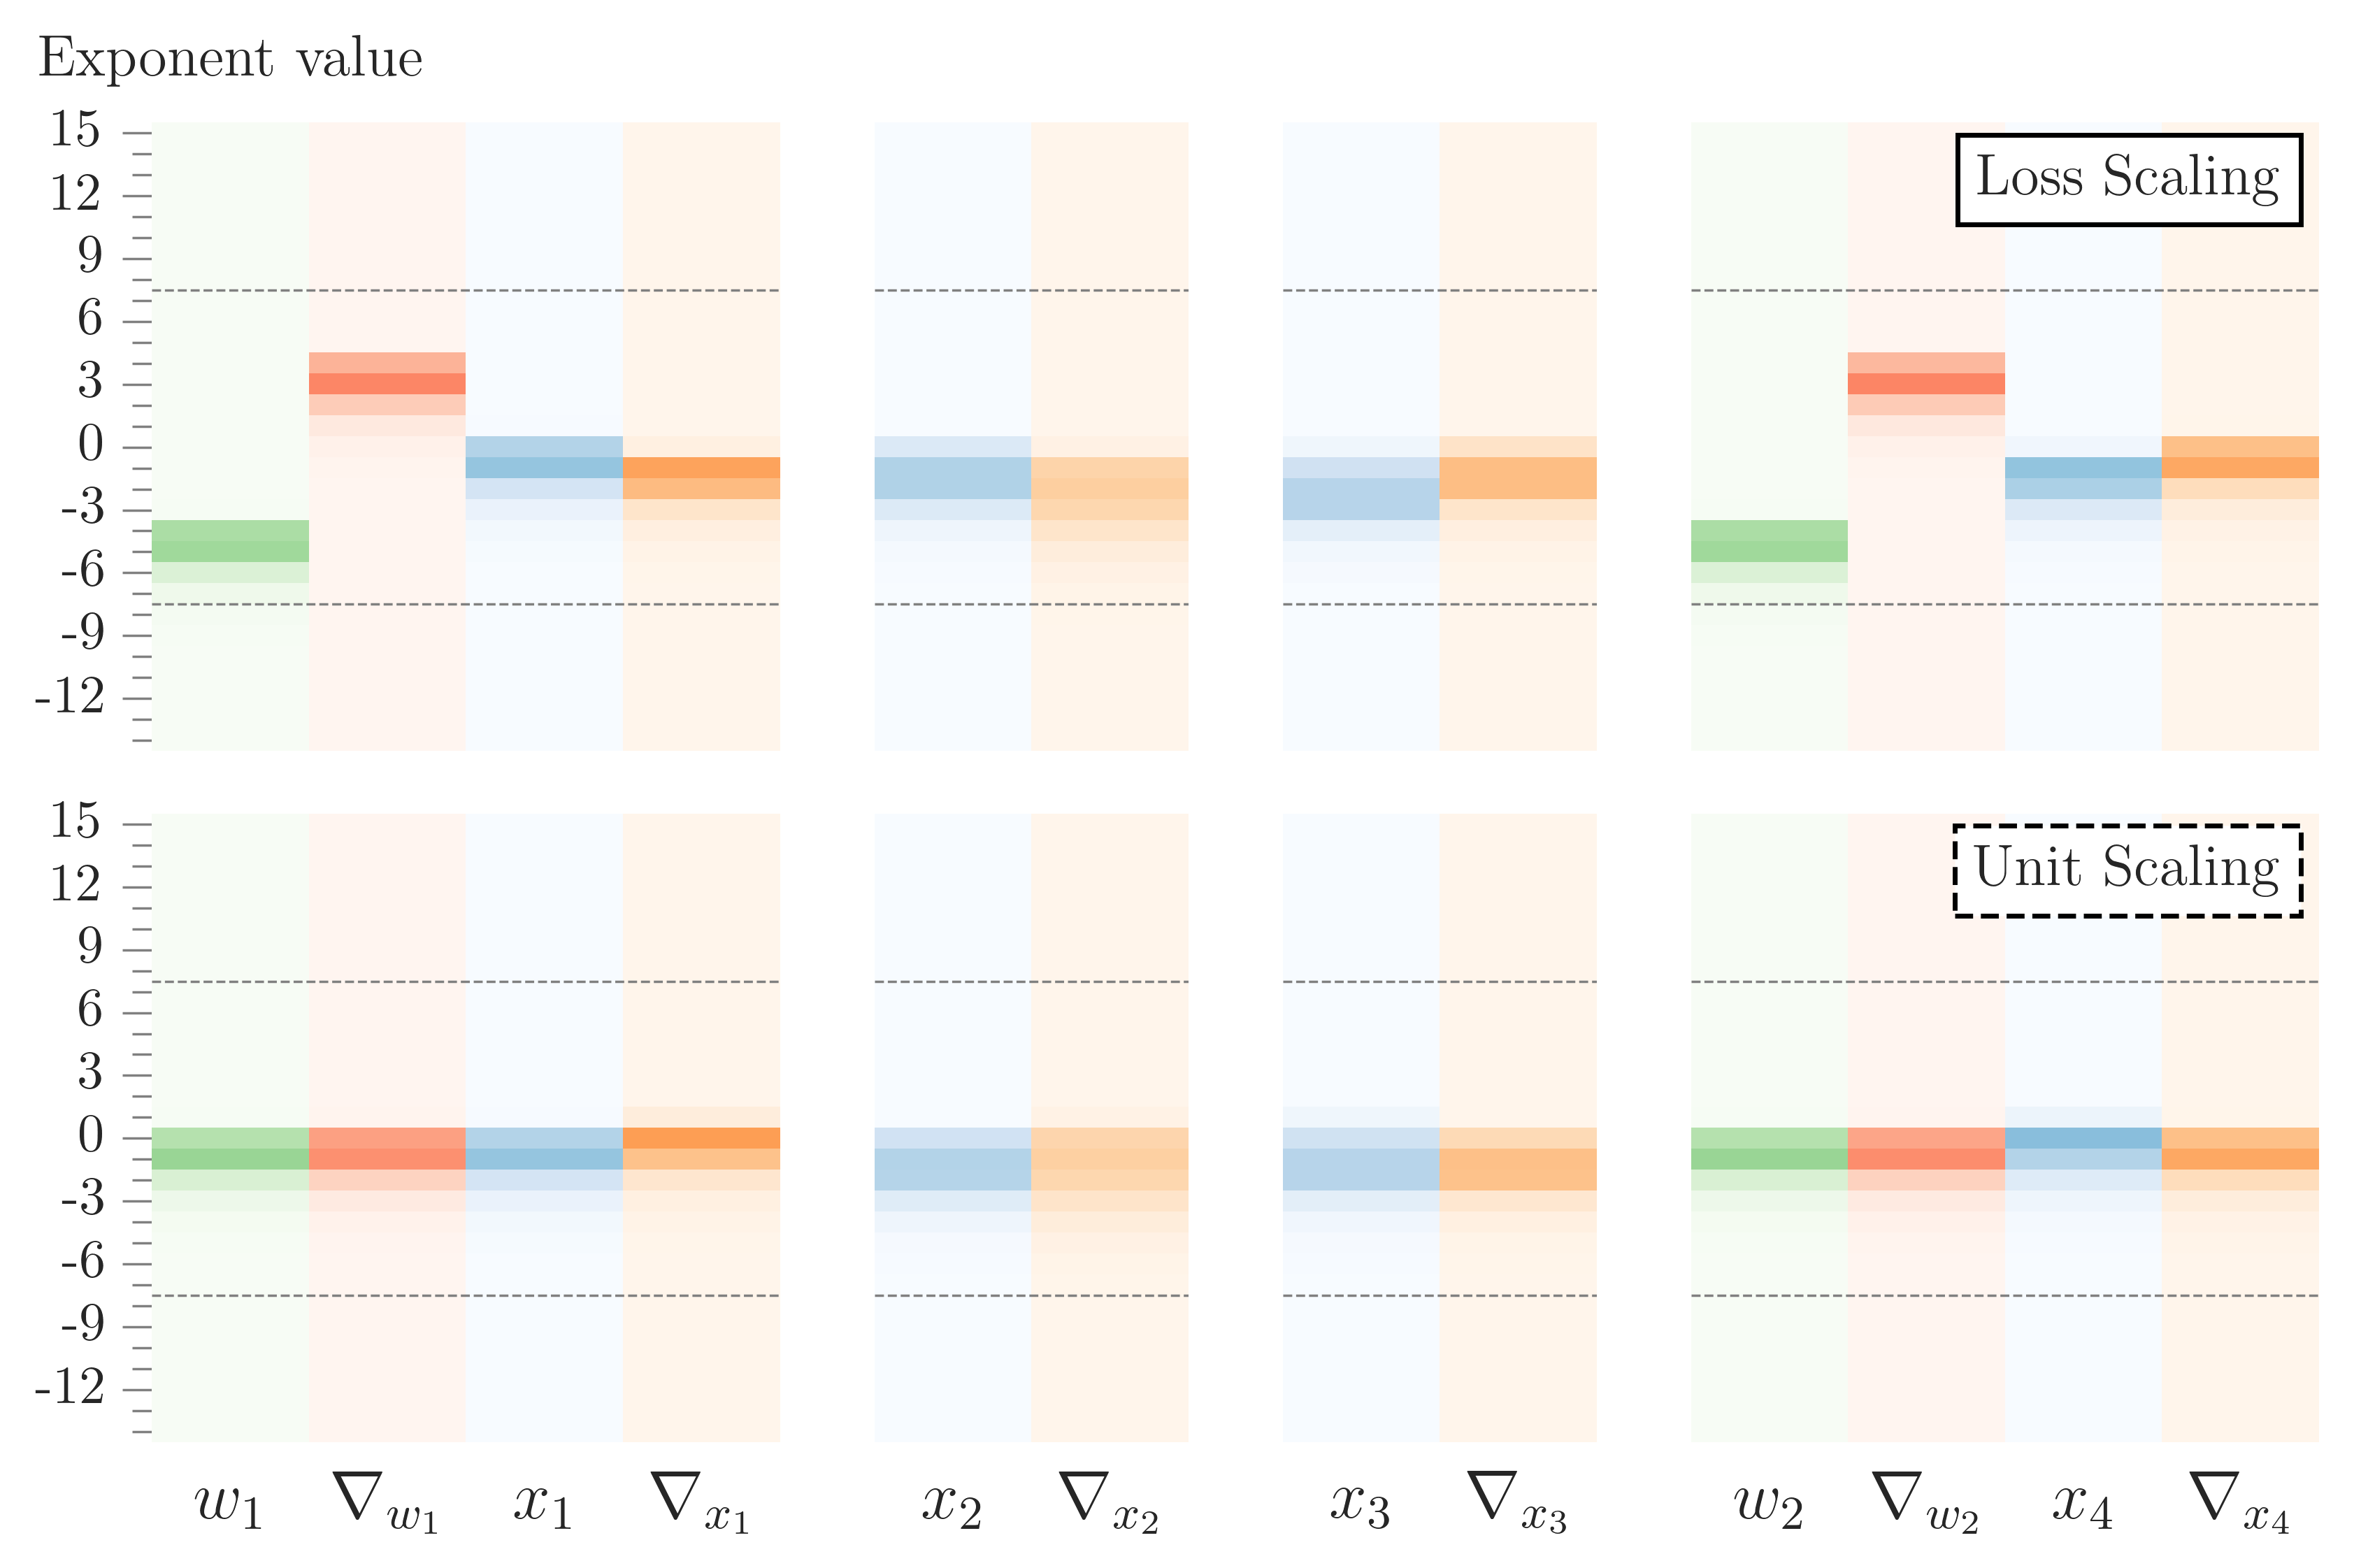

In [ ]:
b, d = 2**14, 1024

reg_inputs = gen_inputs(b, d, w_std=sqrt(2 / (d + 4 * d)))
reg_layer_tensors = ffn_fwd_bwd(*reg_inputs)

us_inputs = gen_inputs(b, d, w_std=1.0)
us_layer_tensors = ffn_fwd_bwd_us(*us_inputs)

analyse(reg_layer_tensors, us_layer_tensors, dpi=500)
plt.savefig('fig_1_lower.pdf', pad_inches=1.0, bbox_inches='tight')